In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime, timedelta

# 1. Background

The [TAGGS](https://taggs.hhs.gov/) website on 2025/03/17 published a list of canceled grants whose action dates range from about 02/20 to 03/12. The justification for this at the time was recorded in banner as: `In accordance with the Presidential Memo "Radical Transparency About Wasteful Spending", information on terminated grants may be accessed through this link`. The link refered to a PDF which can be found in this repository under `/public/official/hhs/pdf/HHS_Grants_Terminated_2025_03_17.pdf`. In this notebook, I will look how well this list matches up with grants which I have detected through changes in RePORTER. I will restrict my analysis to only those grants which now have a project end date between 2025-01-20 and 2025-03-16.

# 2. Retrieve Data

In [2]:
official_canceled_awards = pd.read_csv(
    "../../../public/official/hhs/text/hhs_grants_terminated_fains.txt",
    header = None
).rename({0: "fain"}, axis=1)

In [3]:
altered_projects = pd.concat([
    pd.read_csv("../../../public/weekly/week_of_2025_03_09/data/project_changes_level_1_project_end_and_award_changes.csv"),
    pd.read_csv("../../../public/weekly/week_of_2025_03_09/data/project_changes_level_2_project_end_changes.csv"),
    pd.read_csv("../../../public/weekly/week_of_2025_03_09/data/project_changes_level_3_training_grant_changes.csv"),
    pd.read_csv("../../../public/weekly/week_of_2025_03_16/data/project_changes_level_1_project_end_and_award_changes.csv"),
    pd.read_csv("../../../public/weekly/week_of_2025_03_16/data/project_changes_level_2_project_end_changes.csv"),
    pd.read_csv("../../../public/weekly/week_of_2025_03_16/data/project_changes_level_3_training_grant_changes.csv")
])

select = np.logical_and(
    altered_projects.new_project_end_date >= "2025-01-20",
    altered_projects.new_project_end_date <= "2025-03-16"
)
altered_projects = altered_projects[select].sort_values("new_project_end_date", ascending=False)
altered_projects["fain"] = (
    altered_projects.project_num
                    .str.lstrip("123456789")
                    .str.split('-')
                    .str[0]
)

# 3. Officially canceled altered projects

In [4]:
select = altered_projects.fain.isin(official_canceled_awards.fain)
altered_projects_with_cancelation = altered_projects[select]

altered_projects_with_cancelation.to_csv(
    "/home/jovyan/public/weekly/week_of_2025_03_16/data/project_changes_with_2025_03_17_taggs_cancelation.csv",
    index=False
)

In [5]:
with_cancelation_by_date = pd.DataFrame(
    {
        "new_project_end_date": altered_projects_with_cancelation.new_project_end_date.str[:10],
        "count": 1
    }
).groupby("new_project_end_date").sum().reset_index()

# 4. Altered projects with no official cancelation

In [6]:
select = ~altered_projects.fain.isin(official_canceled_awards.fain)
altered_projects_without_cancelation = altered_projects[select]

altered_projects_without_cancelation.to_csv(
    "/home/jovyan/public/weekly/week_of_2025_03_16/data/project_changes_without_2025_03_17_taggs_cancelation.csv",
    index=False
)

In [7]:
without_cancelation_by_date = pd.DataFrame(
    {
        "new_project_end_date": altered_projects_without_cancelation.new_project_end_date.str[:10],
        "count": 1
    }
).groupby("new_project_end_date").sum().reset_index()

# 5. Plot project counts

/tmp/ipykernel_785492/2745397828.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(
/tmp/ipykernel_785492/2745397828.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(


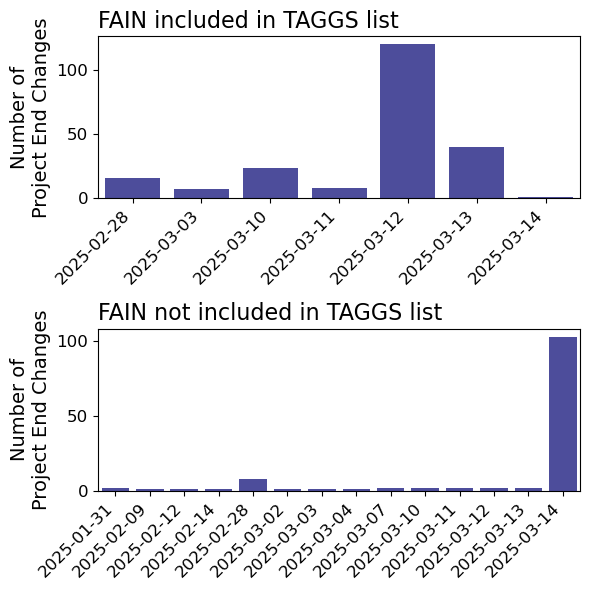

In [8]:
fig, axes = plt.subplots(figsize=[6, 6], nrows=2)

sns.barplot(
    x = "new_project_end_date",
    y = "count",
    data = with_cancelation_by_date,
    color="darkblue",
    alpha = .75,
    ax = axes[0]
)

axes[0].set_title("FAIN included in TAGGS list", size=16, loc="left") 
axes[0].set_xticklabels(
    axes[0].get_xticklabels(), rotation=45, ha="right"
)
axes[0].tick_params(labelsize=12)
axes[0].set_ylabel("Number of\nProject End Changes", size = 14)
axes[0].set_xlabel("")

sns.barplot(
    x = "new_project_end_date",
    y = "count",
    data = without_cancelation_by_date,
    color="darkblue",
    alpha = .75,
    ax = axes[1]
)

axes[1].set_title("FAIN not included in TAGGS list", size=16, loc="left")
axes[1].set_xticklabels(
    axes[1].get_xticklabels(), rotation=45, ha="right"
)
axes[1].tick_params(labelsize=12)
axes[1].set_ylabel("Number of\nProject End Changes", size = 14)
axes[1].set_xlabel("")

plt.tight_layout()
plt.savefig(
    "../../../public/weekly/week_of_2025_03_16/figures/detected_changes_by_inclusion_in_2025_03_17_taggs_list.png",
    dpi=300
)
plt.show()